# Forecasting with Durbyn.jl

This chapter covers the full suite of forecasting models in Durbyn.jl. We cover two interfaces:

1. **Array Interface** — Direct functions that operate on numeric vectors. Best for quick single-series analysis.
2. **Formula Interface** — Declarative model specification using `@formula` and model specs. Best for panel data, model comparison, and production workflows.

## The Tidy Forecasting Workflow

Durbyn follows the **tidy forecasting workflow** Hyndman & Athanasopoulos (2021):

```
Data → PanelData → Model Spec → fit() → forecast() → accuracy()
```


Each step produces a well-defined object that flows into the next.

## Setup

In [1]:
using Durbyn
using Durbyn.TableOps
using Durbyn.Grammar
using Durbyn.ModelSpecs
using CSV, Tables, Plots
import Durbyn: plot

# Load M3 monthly data
data_dir = joinpath(@__DIR__, "..", "data")
tbl = Tables.columntable(CSV.File(joinpath(data_dir, "M3_MONTHLY.csv")))

# Prepare train/test
train_all = query(tbl, row -> row.value_type == "x")
test_all  = query(tbl, row -> row.value_type == "xx")

# Extract a single series for array-interface examples
single = query(train_all, row -> row.series == "N1402")
y = Float64.(single.value)
m = 12

# Also load the built-in air passengers dataset
ap = air_passengers()

┌ Info: Durbyn.jl is under active development.
│ API may change without notice. Bugs and performance issues may exist.
│ Please report issues at: https://github.com/taf-society/Durbyn.jl/issues
└ @ Durbyn /home/akayr/Development/Open Source/Julia/Durbyn.jl/src/Durbyn.jl:90


144-element Vector{Float64}:
 112.0
 118.0
 132.0
 129.0
 121.0
 135.0
 148.0
 148.0
 136.0
 119.0
   ⋮
 461.0
 472.0
 535.0
 622.0
 606.0
 508.0
 461.0
 390.0
 432.0


---

## Part I: Benchmark Methods

### Naive Methods (Array Interface)

Benchmark methods provide baselines against which we evaluate more sophisticated models.

#### Simple Naive

The naive method uses the last observation as the forecast: $\hat{y}_{T+h|T} = y_T$.

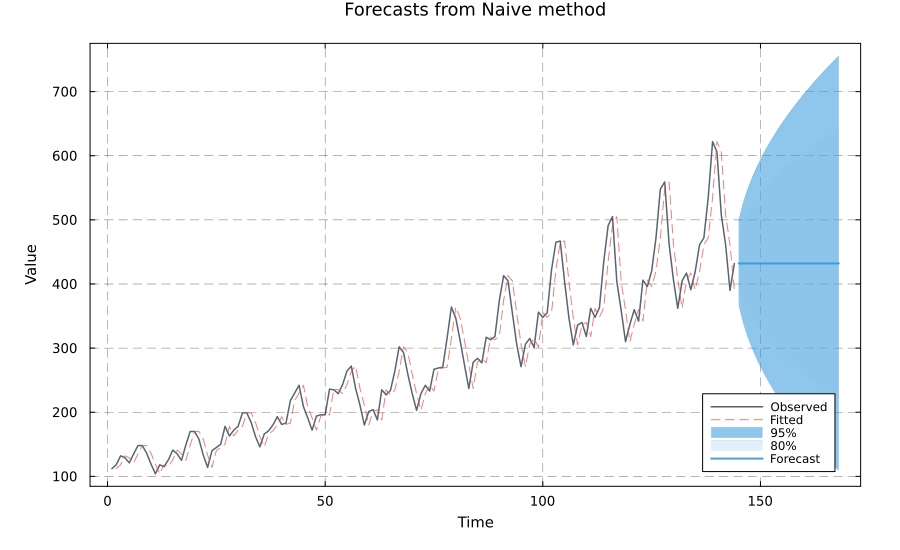

In [3]:
using Durbyn
import Durbyn: plot

ap = air_passengers()

naive_fit = naive(ap)
naive_fc = forecast(naive_fit, h=24)
plot(naive_fc)


#### Seasonal Naive

Uses the value from the same season last year: $\hat{y}_{T+h|T} = y_{T+h-m(k+1)}$ where $k = \lfloor(h-1)/m\rfloor$.

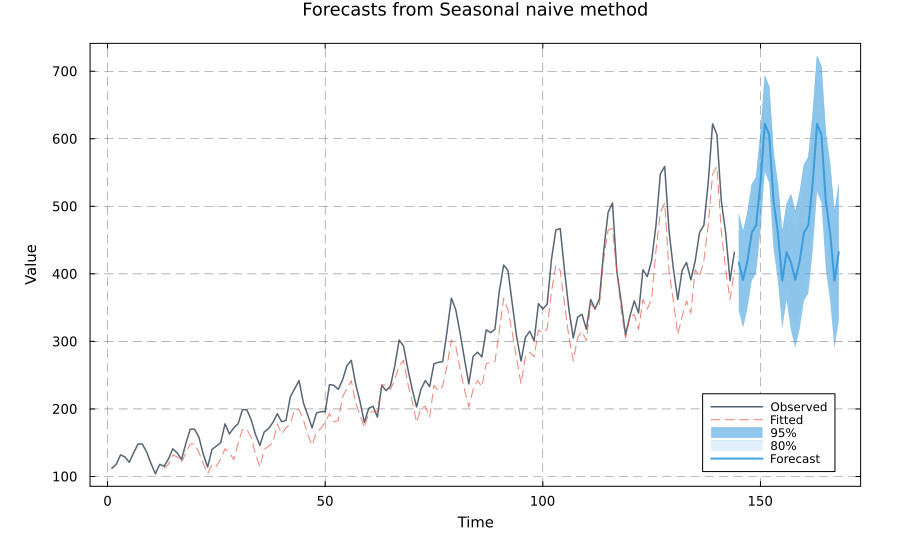

In [4]:
snaive_fit = snaive(ap, 12)
snaive_fc = forecast(snaive_fit, h=24)
plot(snaive_fc)


#### Random Walk with Drift

$\hat{y}_{T+h|T} = y_T + h \cdot \frac{y_T - y_1}{T - 1}$

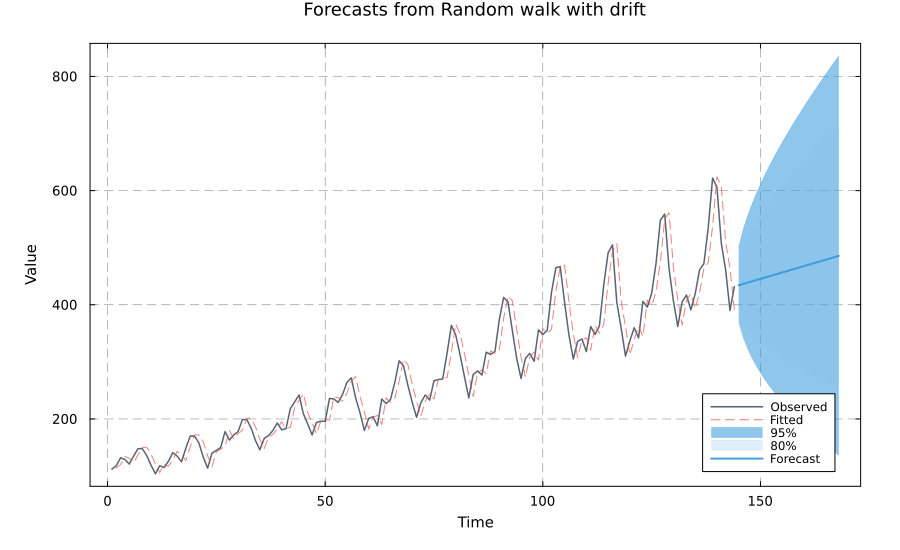

In [5]:
rw_fit = rw(ap)
rw_fc = forecast(rw_fit, h=24)
plot(rw_fc)

# Random walk with drift (equivalent)
rwf_fit = rw(ap, drift=true)
rwf_fc = forecast(rwf_fit, h=24)
plot(rwf_fc)


#### Mean Forecast

$\hat{y}_{T+h|T} = \bar{y}$

In [12]:
mean_fit = meanf(ap, 1)
mean_fc = forecast(mean_fit, h=24)
#plot(mean_fc)

Forecast from Mean method
-------------------------------
Forecast horizon: 24 steps
Confidence levels: [80.0, 95.0]

First 5 point forecasts:
[280.2986, 280.2986, 280.2986, 280.2986, 280.2986]

Last 5 observations:
[606.0, 508.0, 461.0, 390.0, 432.0]

Last 5 fitted values:
[280.2986, 280.2986, 280.2986, 280.2986, 280.2986]

Last 5 residuals:
[325.7014, 227.7014, 180.7014, 109.7014, 151.7014]



### Naive Methods (Formula Interface)

In [13]:
data = (value = ap,)

# Naive
spec = NaiveSpec(@formula(value = naive_term()))
fc = forecast(fit(spec, data), h=24)

# Seasonal Naive
spec = SnaiveSpec(@formula(value = snaive_term()); m=12)
fc = forecast(fit(spec, data, m=12), h=24)

# Random Walk
spec = RwSpec(@formula(value = rw_term(drift=true)))
fc = forecast(fit(spec, data), h=24)

# Mean
spec = MeanfSpec(@formula(value = meanf_term()))
fc = forecast(fit(spec, data), h=24)

Forecast from Mean method
-------------------------------
Forecast horizon: 24 steps
Confidence levels: [80.0, 95.0]

First 5 point forecasts:
[280.2986, 280.2986, 280.2986, 280.2986, 280.2986]

Last 5 observations:
[606.0, 508.0, 461.0, 390.0, 432.0]

Last 5 fitted values:
[280.2986, 280.2986, 280.2986, 280.2986, 280.2986]

Last 5 residuals:
[325.7014, 227.7014, 180.7014, 109.7014, 151.7014]



---

## Part II: Exponential Smoothing (ETS)

ETS models are a family of state-space models where the forecast is a weighted combination of past observations with exponentially decaying weights Hyndman et al. (2002).

### The ETS Taxonomy

Each ETS model is identified by three letters: **E**rror, **T**rend, **S**eason:

| Component | Options |
|-----------|---------|
| **Error** (E) | A (Additive), M (Multiplicative) |
| **Trend** (T) | N (None), A (Additive), M (Multiplicative) |
| **Season** (S) | N (None), A (Additive), M (Multiplicative) |

Additionally, trends can be **damped** ($\phi < 1$). With `Z` = automatic selection.

This gives 30 model combinations, selected by minimising the AICc.

### Simple Exponential Smoothing (SES)

SES is ETS(A,N,N): additive errors, no trend, no seasonality.

$$
\begin{aligned}
\hat{y}_{t+1|t} &= \ell_t \\
\ell_t &= \alpha y_t + (1 - \alpha)\ell_{t-1}
\end{aligned}
$$

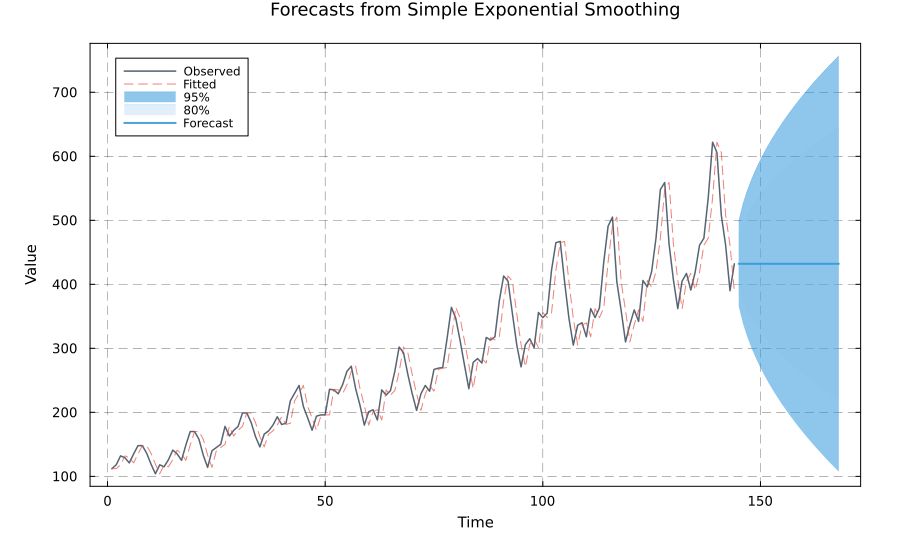

In [14]:
using Durbyn.ExponentialSmoothing
# Array interface
ses_fit = ExponentialSmoothing.ses(ap)
ses_fc = forecast(ses_fit, h=24)
plot(ses_fc)

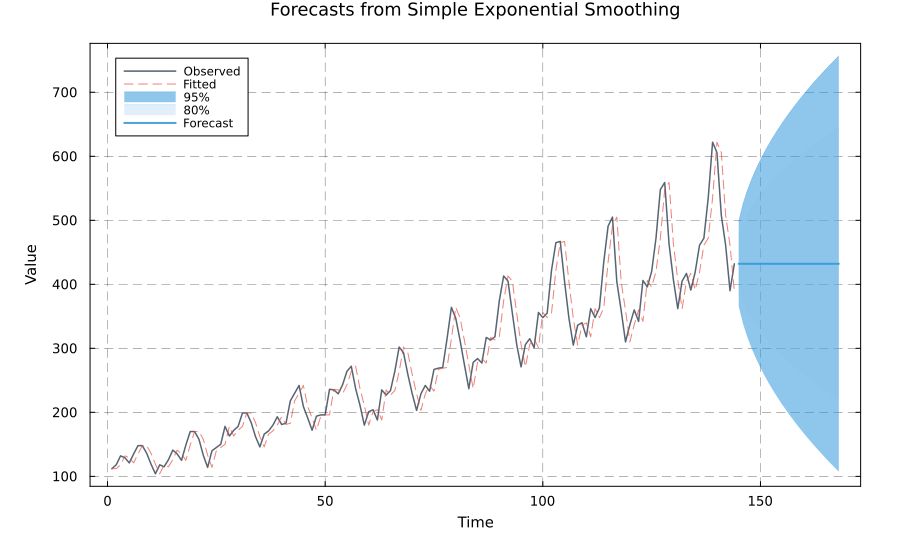

In [24]:
using Durbyn.Grammar
# Formula interface
spec = SesSpec(@formula(value = Grammar.ses()))
fitted_ses = fit(spec, (value=ap,))
fc = forecast(fitted_ses, h=24)
plot(fc)


### Holt's Linear Method

Holt's method is ETS(A,A,N): additive errors and trend, no seasonality.

$$
\begin{aligned}
\hat{y}_{t+h|t} &= \ell_t + hb_t \\
\ell_t &= \alpha y_t + (1-\alpha)(\ell_{t-1} + b_{t-1}) \\
b_t &= \beta^*(\ell_t - \ell_{t-1}) + (1-\beta^*)b_{t-1}
\end{aligned}
$$

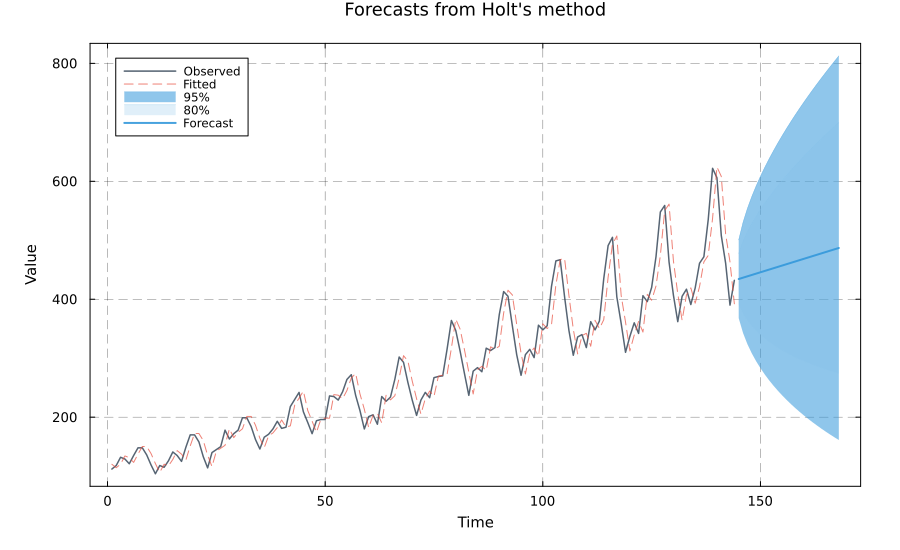

In [15]:
using Durbyn.ExponentialSmoothing
# Array interface
holt_fit = ExponentialSmoothing.holt(ap)
holt_fc = forecast(holt_fit, h=24)
plot(holt_fc)

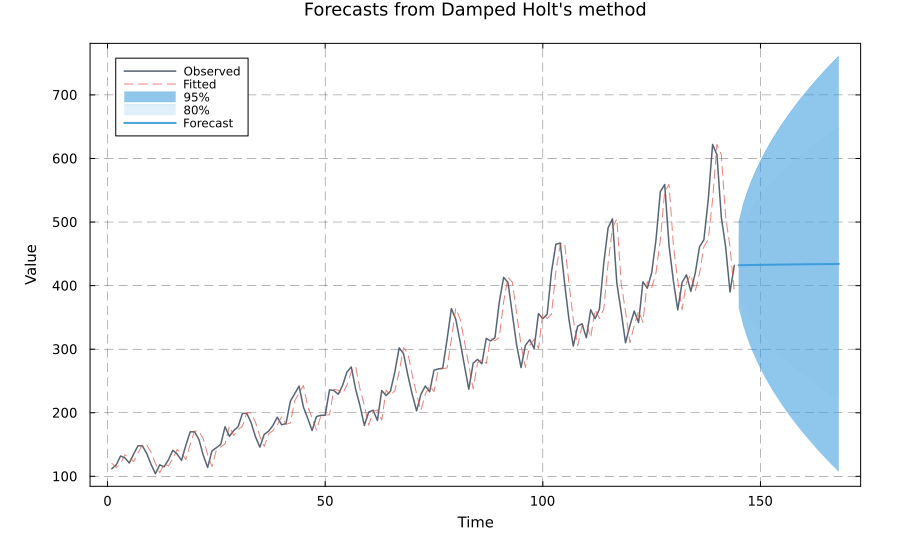

In [27]:
# With damping
holt_d_fit = ExponentialSmoothing.holt(ap, damped=true)
holt_d_fc = forecast(holt_d_fit, h=24)
plot(holt_d_fc)

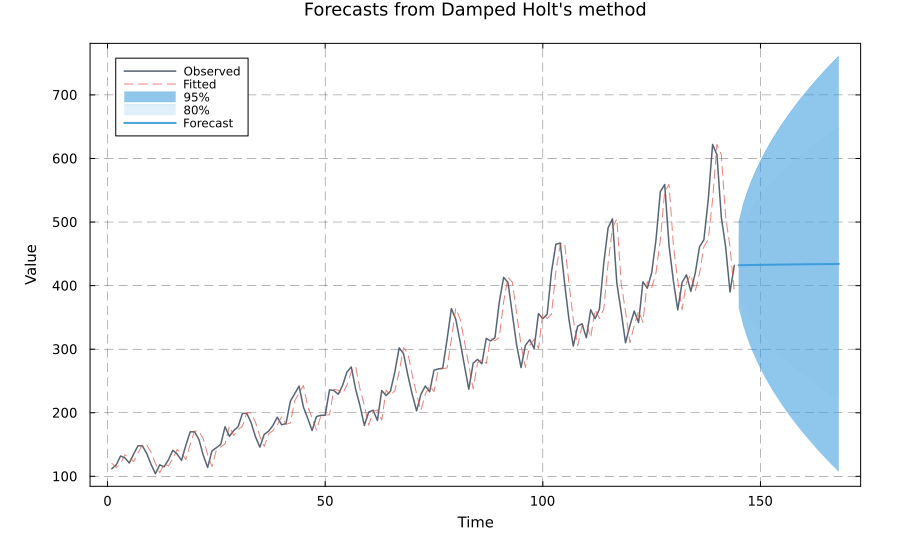

In [32]:
using Durbyn.Grammar
# Formula interface
spec = HoltSpec(@formula(value = Grammar.holt(damped=true)))
fitted_holt = fit(spec, (value=ap,))
fc = forecast(fitted_holt, h=24)
plot(fc)


### Holt-Winters' Method

Extends Holt's method with a seasonal component.

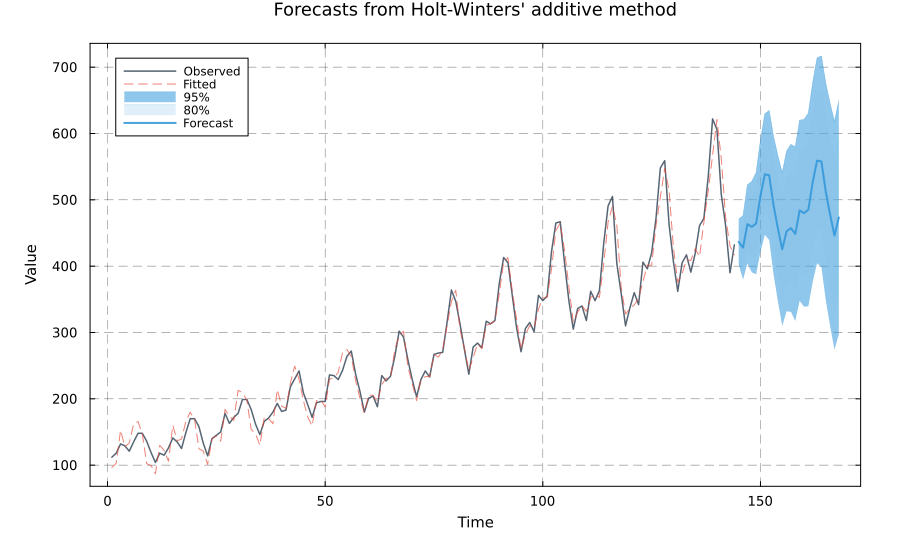

In [35]:
# Array interface — additive seasonality
hw_add = ExponentialSmoothing.holt_winters(ap, 12, seasonal="additive")
hw_add_fc = forecast(hw_add, h=24)

plot(hw_add_fc)

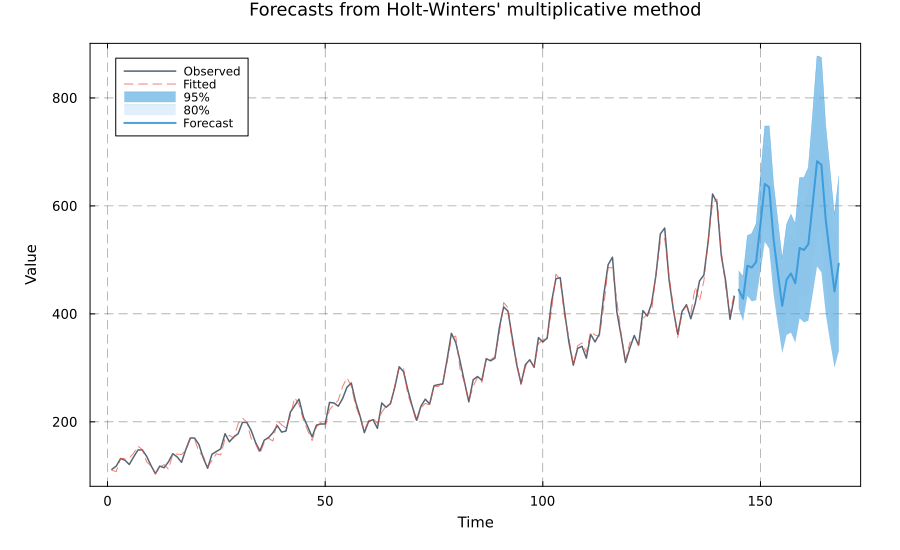

In [36]:
# Multiplicative seasonality
hw_mul = ExponentialSmoothing.holt_winters(ap, 12, seasonal="multiplicative")
hw_mul_fc = forecast(hw_mul, h=24)
plot(hw_mul_fc)

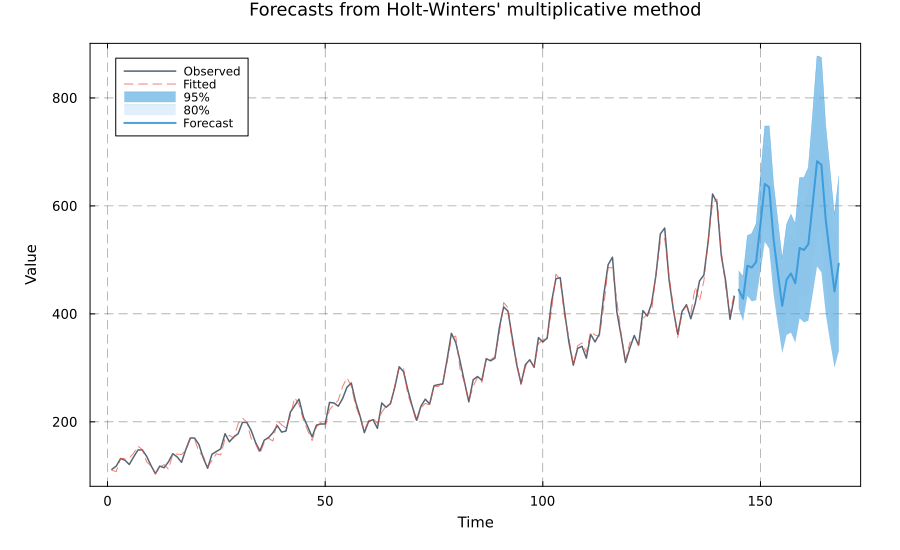

In [37]:


# Formula interface
spec = HoltWintersSpec(
    @formula(value = Grammar.hw(seasonal="multiplicative"));
    m = 12
)
fitted_hw = fit(spec, (value=ap,), m=12)
fc = forecast(fitted_hw, h=24)
plot(fc)


### Automatic ETS

Let Durbyn select the best ETS model by minimising AICc:

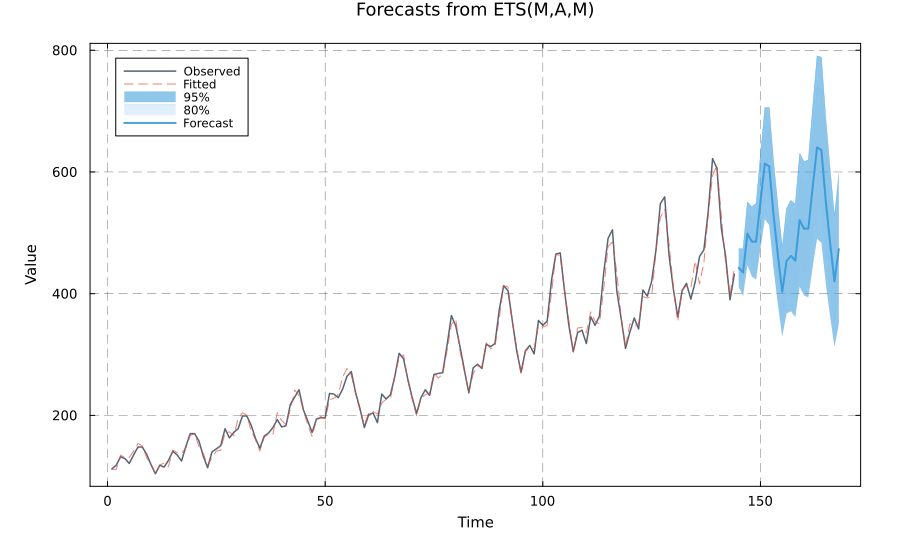

In [17]:
# Array interface: "ZZZ" means auto-select all components
using Durbyn.ExponentialSmoothing

ets_fit = ets(ap, 12, "ZZZ")
ets_fc = forecast(ets_fit, h=24)
plot(ets_fc)
# Check selected model
#summary(ets_fit)

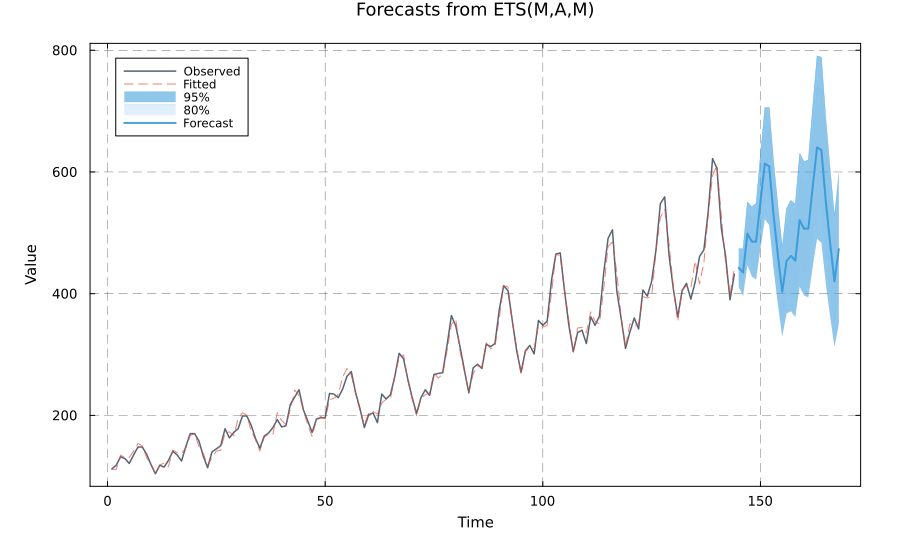

In [42]:
# Formula interface
spec = EtsSpec(@formula(value = e("Z") + t("Z") + s("Z")))
fitted_ets = fit(spec, (value=ap,), m=12)
fc = forecast(fitted_ets, h=24)
plot(fc)


### ETS with Box-Cox

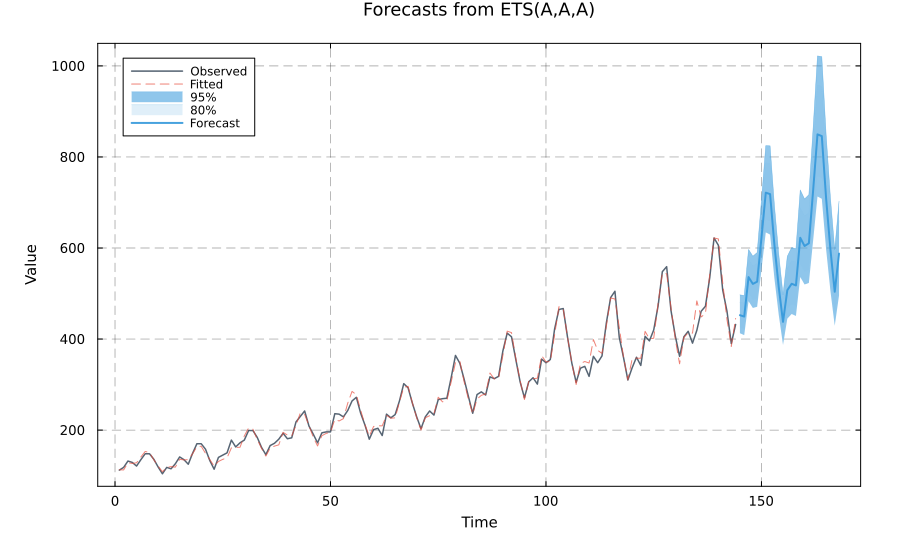

In [44]:
# Apply Box-Cox before fitting
ets_fit_bc = ets(ap, 12, "ZZZ", lambda="auto")
ets_fc_bc = forecast(ets_fit_bc, h=24)
plot(ets_fc_bc)


---

## Part III: ARIMA Models

ARIMA (AutoRegressive Integrated Moving Average) models capture temporal dependence through:

- **AR($p$)**: regression on past values
- **I($d$)**: differencing for stationarity
- **MA($q$)**: regression on past forecast errors

The seasonal extension is SARIMA$(p,d,q)(P,D,Q)_m$.

### Manual ARIMA (Array Interface)

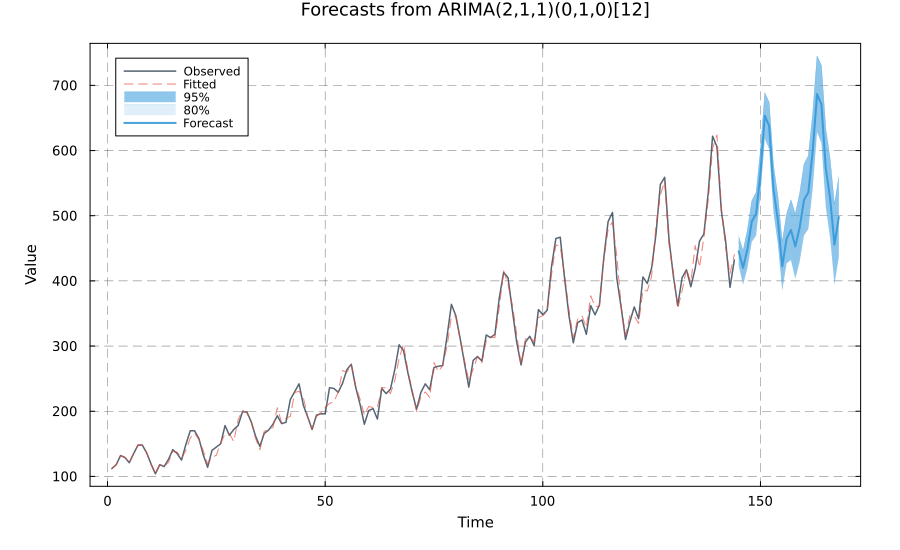

In [45]:
using Durbyn.Arima

# Fit ARIMA(2,1,1)(0,1,0)₁₂
arima_fit = arima(ap, 12, order=PDQ(2,1,1), seasonal=PDQ(0,1,0))

# Forecast
arima_fc = forecast(arima_fit, h=24)
plot(arima_fc)

In [46]:

# Diagnostics
summary(arima_fit)

"ArimaFit"

In [48]:
residuals(arima_fit)
fitted(arima_fit)

144-element Vector{Float64}:
 111.93533678260478
 117.96643415513454
 131.96619385109918
 128.97744814625295
 120.98924612250487
 134.978174117408
 147.96920710985165
 147.9730724206285
 135.98742509198294
 119.004856126628
   ⋮
 420.82140799861816
 467.08531845246625
 524.1014955665311
 603.556122671469
 623.8949420675209
 514.529276590352
 450.76738492466956
 410.6849367226617
 440.37785009987084


### Automatic ARIMA (Array Interface)

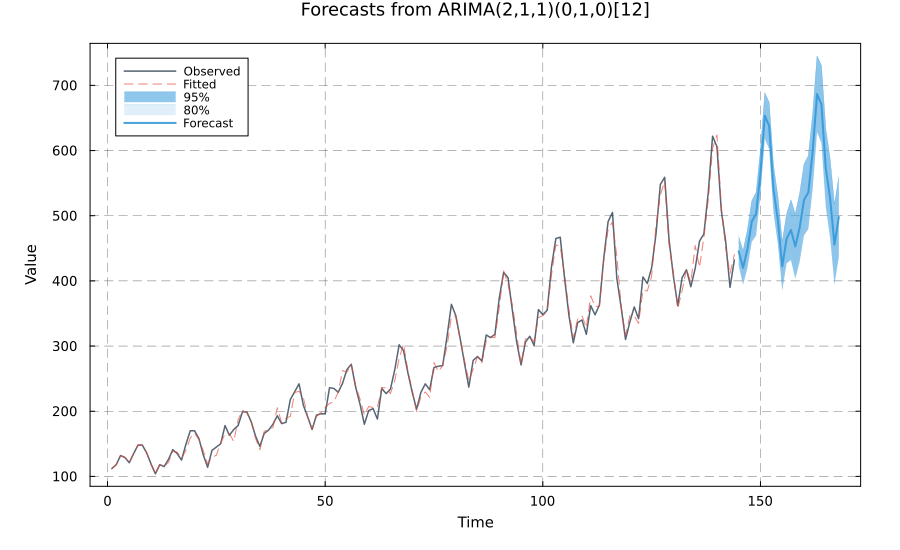

In [49]:
# Let Durbyn select the best ARIMA model
auto_fit = auto_arima(ap, 12)

# Forecast
auto_fc = forecast(auto_fit, h=24)
plot(auto_fc)


### ARIMA (Formula Interface)

In [50]:
data = (value = ap,)

# Auto ARIMA — empty p(), q(), etc. means search over ranges
spec = ArimaSpec(@formula(value = p() + q() + d() + P() + Q() + D()))
fitted_arima = fit(spec, data, m=12)
fc = forecast(fitted_arima, h=24)

# Fixed orders
spec_fixed = ArimaSpec(@formula(value = p(2) + d(1) + q(1) + P(0) + D(1) + Q(0)))
fitted_fixed = fit(spec_fixed, data, m=12)

# Search within ranges
spec_range = ArimaSpec(@formula(value = p(1,3) + q(1,3) + d(1) + P(0,1) + D(1) + Q(0,1)))
fitted_range = fit(spec_range, data, m=12)

FittedArima
  Model: ARIMA(2,1,1)
         (0,1,0)[12]
  AIC:  1017.9399
  AICc: 1018.2574
  BIC:  1029.4407
  σ²:   129.335181
  n:    131



### ARIMA with Regressors (ARIMAX)

In [51]:
# Create data with regressors
n = length(ap)
data_reg = (
    value       = ap,
    trend       = collect(1:n) ./ n,
    fourier_sin = sin.(2π .* collect(1:n) ./ 12)
)

spec = ArimaSpec(@formula(value = p(1,3) + q(1,3) + trend + fourier_sin))
fitted_arimax = fit(spec, data_reg, m=12)

# Forecast requires future regressor values
newdata = (
    trend       = collect((n+1):(n+24)) ./ n,
    fourier_sin = sin.(2π .* collect((n+1):(n+24)) ./ 12)
)
fc = forecast(fitted_arimax, h=24, newdata=newdata)

Forecast from Regression with ARIMA(2,1,1)(0,1,0)[12] errors
-------------------------------
Forecast horizon: 24 steps
Confidence levels: [80, 95]

First 5 point forecasts:
[4.8091352932506625e13, -1.1959016646630656e14, -1.7974257825138694e14, -1.1573107158349702e14, 5.580954269804169e13]

Last 5 observations:
[606.0, 508.0, 461.0, 390.0, 432.0]

Last 5 fitted values:
[625.4688, 518.1875, 455.1875, 410.0, 439.3906]

Last 5 residuals:
[-19.4688, -10.1875, 5.8125, -20.0, -7.3906]



---

## Part IV: BATS and TBATS

### BATS — Box-Cox, ARMA Errors, Trend, Seasonal

BATS De Livera et al. (2011) is a state-space model designed for complex seasonal patterns with **integer seasonal periods**:

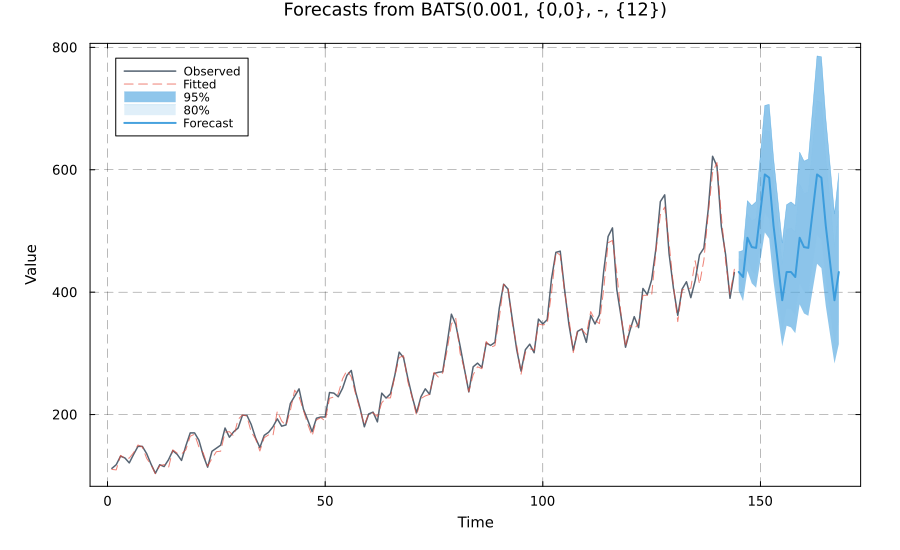

In [5]:
# Array interface
bats_fit = bats(ap, 12)
bats_fc = forecast(bats_fit, h=24)
plot(bats_fc)

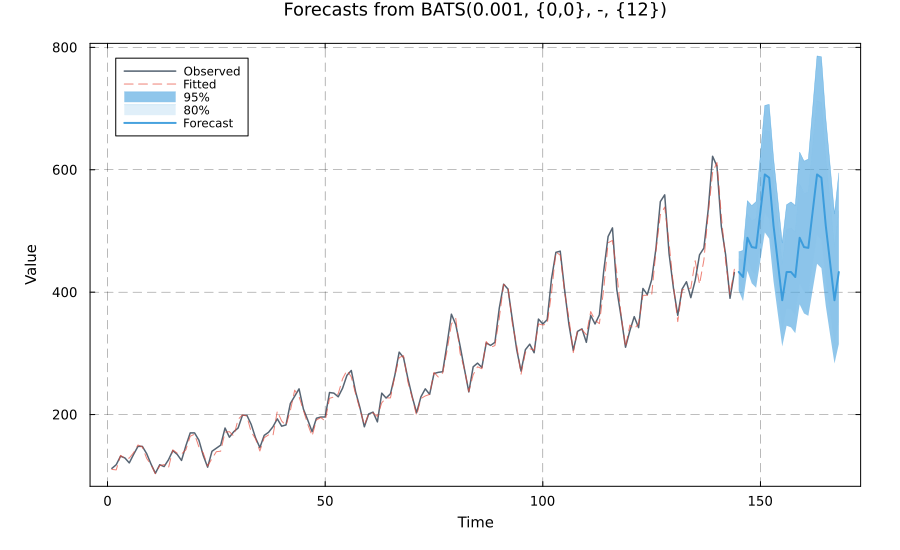

In [6]:

# Formula interface
 spec = BatsSpec(@formula(value = bats(m=12)))                                                                                                         
  fitted_bats = fit(spec, (value=ap,))                                                                                                                                   
  fc = forecast(fitted_bats, h=24)
  plot(fc)


### TBATS — Trigonometric Seasonal BATS

TBATS extends BATS with **Fourier representations** for seasonal components, enabling:

- Non-integer seasonal periods (e.g., 52.18 weeks/year)
- Very long seasonal cycles
- Multiple seasonal periods

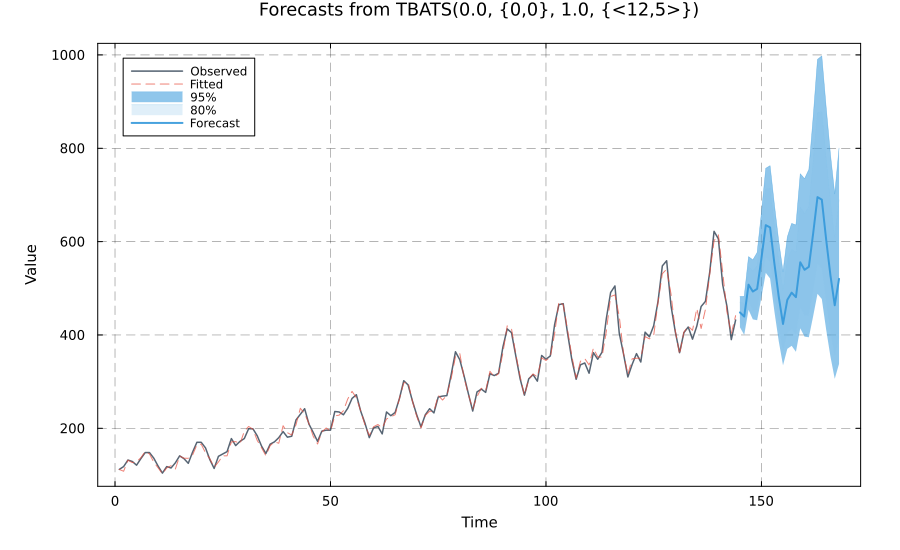

In [7]:
# Array interface
tbats_fit = tbats(ap, 12)
tbats_fc = forecast(tbats_fit, h=24)
plot(tbats_fc)

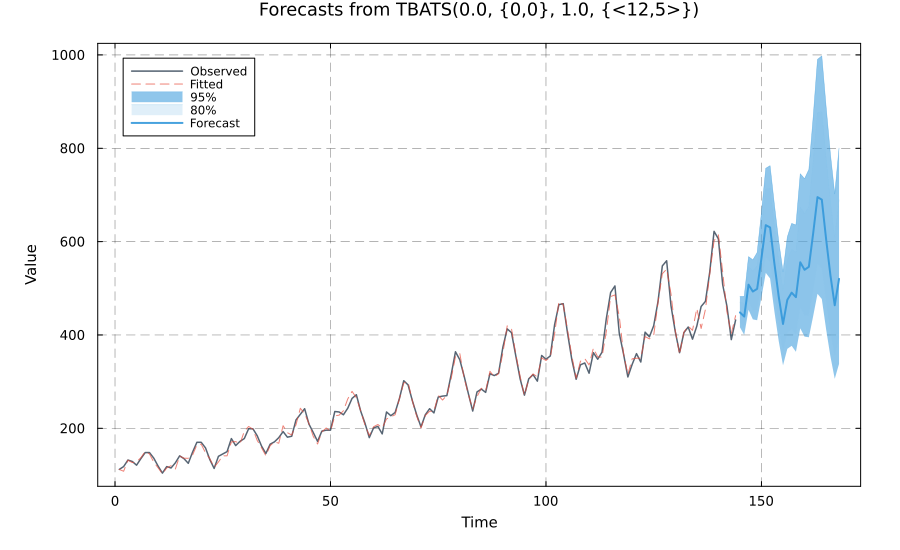

In [8]:
# Formula interface
spec = TbatsSpec(@formula(value = tbats(m=12)))
fitted_tbats = fit(spec, (value=ap,))
fc = forecast(fitted_tbats, h=24)
plot(fc)

> 💡 **Tip**: BATS vs TBATS
>
>
> | Feature | BATS | TBATS |
> |---------|------|-------|
> | Seasonal periods | Integer only | Any (including non-integer) |
> | Very long seasons | Expensive ($O(m)$ states) | Efficient ($O(k)$ where $k \ll m$) |
> | Multiple seasons | Yes | Yes |
> | Box-Cox | Yes | Yes |
> | ARMA errors | Yes | Yes |
>
> **Rule of thumb**: Use BATS for standard seasonal data (monthly, quarterly). Use TBATS for high-frequency or multi-seasonal data.


---

## Part V: Theta Method

The Theta method decomposes a time series into "theta lines" and combines forecasts from each. Durbyn implements the Dynamic Optimised Theta Method (DOTM) Fiorucci et al. (2016).

### Variants

| Variant | Description |
|---------|-------------|
| **STM** | Standard Theta Method |
| **OTM** | Optimised Theta Method |
| **DSTM** | Dynamic Standard Theta Method |
| **DOTM** | Dynamic Optimised Theta Method (recommended) |

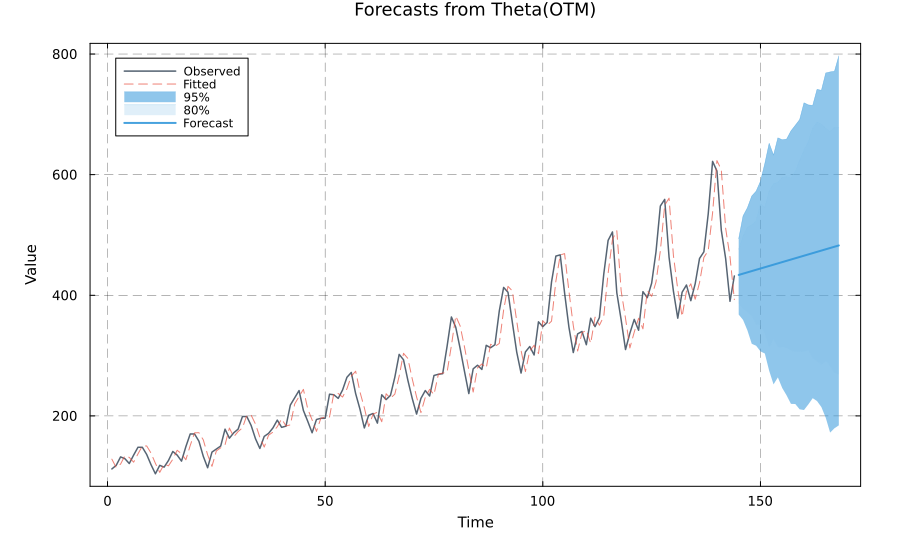

In [4]:
# Array interface
theta_fit = theta(ap, 12)
theta_fc = forecast(theta_fit, h=24)
plot(theta_fc)

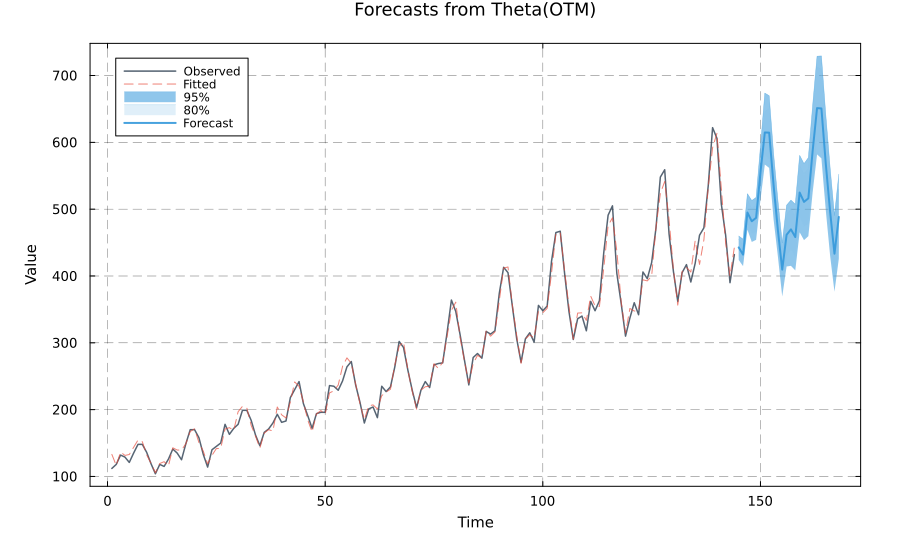

In [6]:
# Auto Theta — tries all variants, selects best by IC
auto_theta_fit = auto_theta(ap, 12)
auto_theta_fc = forecast(auto_theta_fit, h=24)
plot(auto_theta_fc)

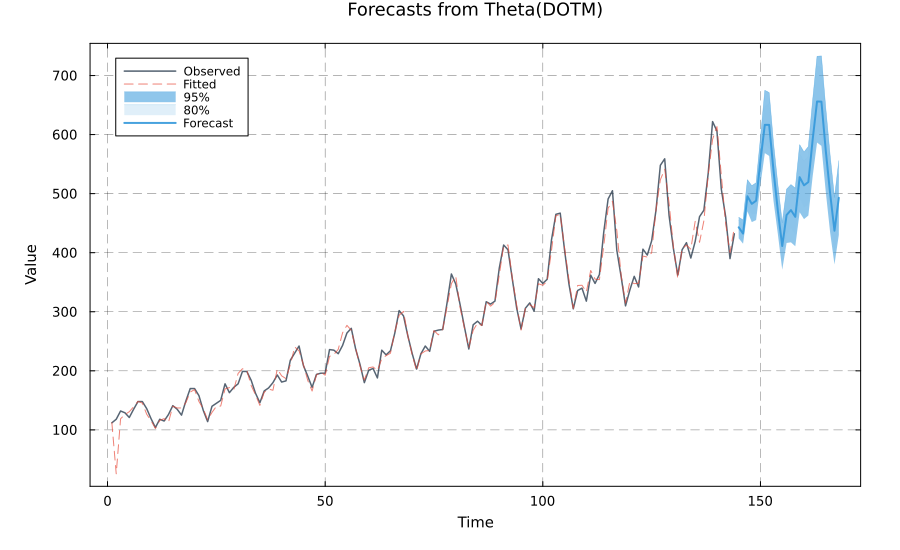

In [5]:
# Formula interface for Theta model
spec = ThetaSpec(@formula(value = theta(
      model = :DOTM,
      decomposition = "multiplicative",
      nmse = 5
  )), m = 12)

fitted_theta = fit(spec, (value=ap,))
fc = forecast(fitted_theta, h=24)
plot(fc)

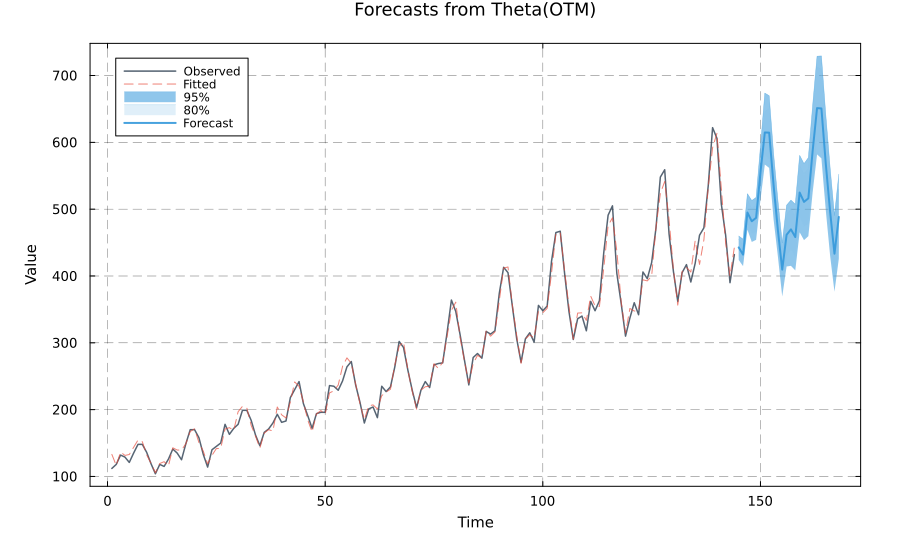

In [6]:
# Auto-select (tries all 4 variants, picks best)                                                                                                                    
spec = ThetaSpec(@formula(value = theta()), m = 12)

fitted_theta = fit(spec, (value=ap,))
fc = forecast(fitted_theta, h=24)
plot(fc)                                                                                                       
                                                                                                                                                                         

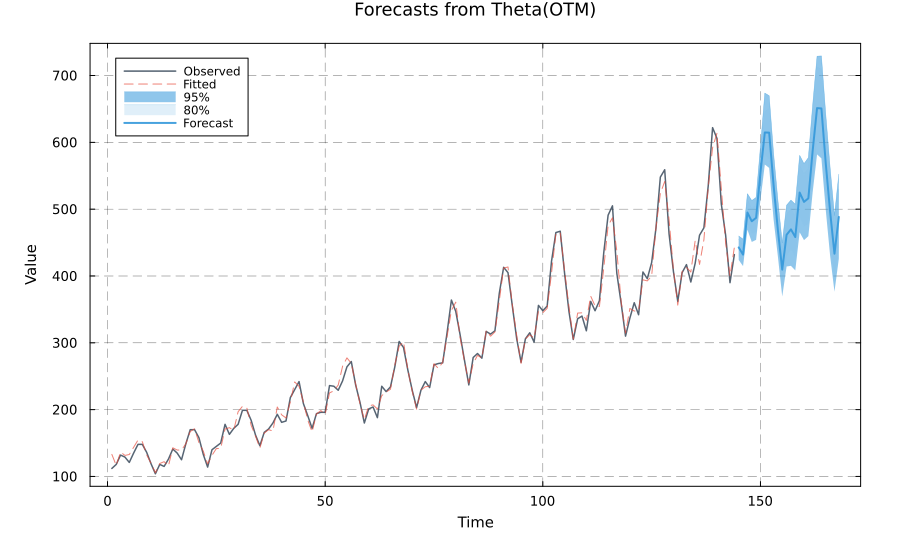

In [7]:
#  Auto-select with decomposition                                                                                                                    
spec = ThetaSpec(@formula(value = theta(decomposition="multiplicative")), m = 12)

fitted_theta = fit(spec, (value=ap,))
fc = forecast(fitted_theta, h=24)
plot(fc)  


---

## Part VI: ARAR and ARARMA

ARAR (Autoregressive AR) applies memory-shortening transformations before fitting an AR model. ARARMA extends this with an ARMA model on the transformed data.

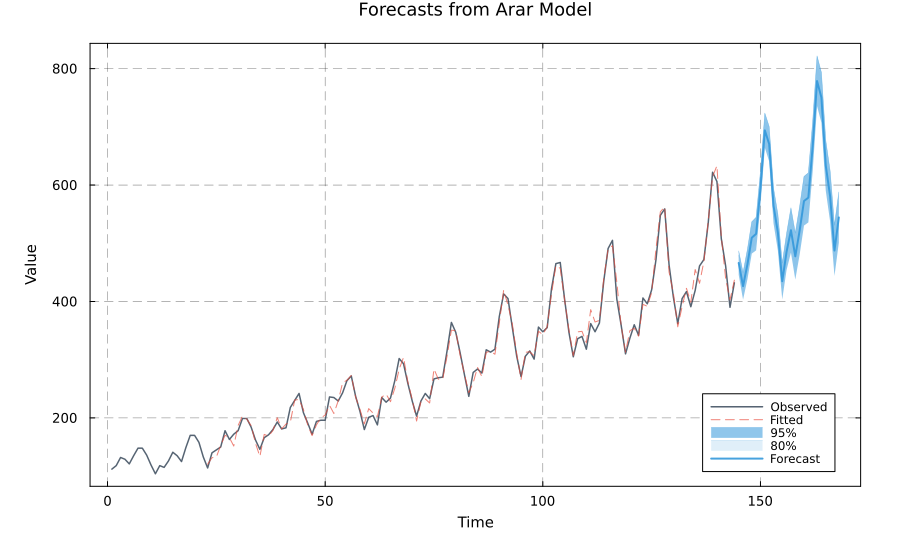

In [9]:
using Durbyn.Ararma

# ARAR — array interface
arar_fit = arar(ap, max_ar_depth=13)
arar_fc = forecast(arar_fit, h=24)
plot(arar_fc)

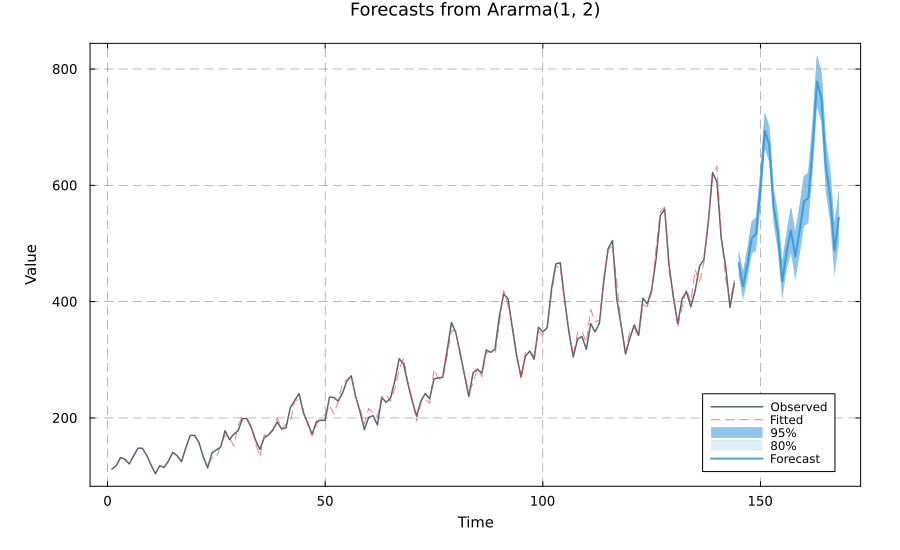

In [10]:
# ARARMA with fixed orders
ararma_fit = ararma(ap, p=1, q=2)
ararma_fc = forecast(ararma_fit, h=24)
plot(ararma_fc)

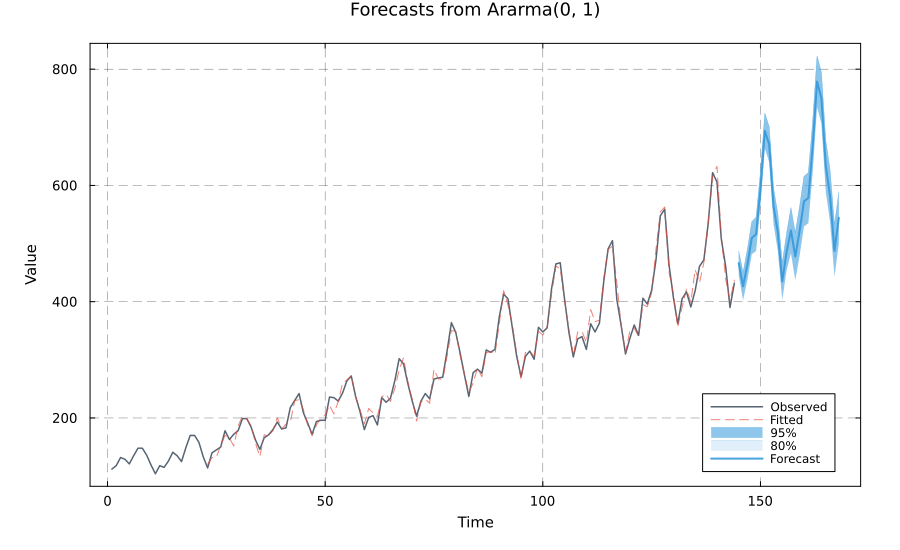

In [11]:

# Auto ARARMA — automatic order selection
auto_ararma_fit = auto_ararma(ap, max_p=3, max_q=2, crit=:bic)
auto_ararma_fc = forecast(auto_ararma_fit, h=24)
plot(auto_ararma_fc)

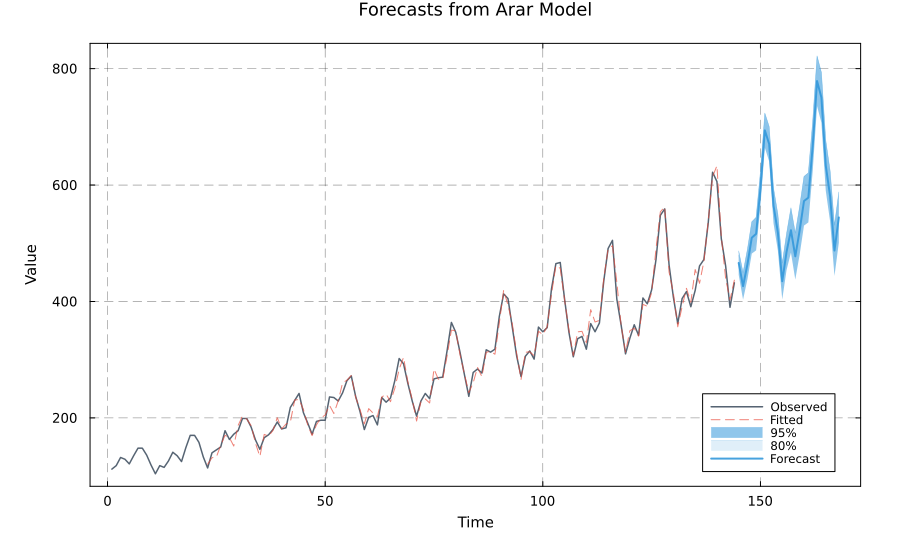

In [ ]:

# ARAR Formula interface
spec = ArarSpec(@formula(value = arar(max_ar_depth=20, max_lag=30)))
fitted_arar = fit(spec, (value=ap,))
fc = forecast(fitted_arar, h=24)
plot(fc)

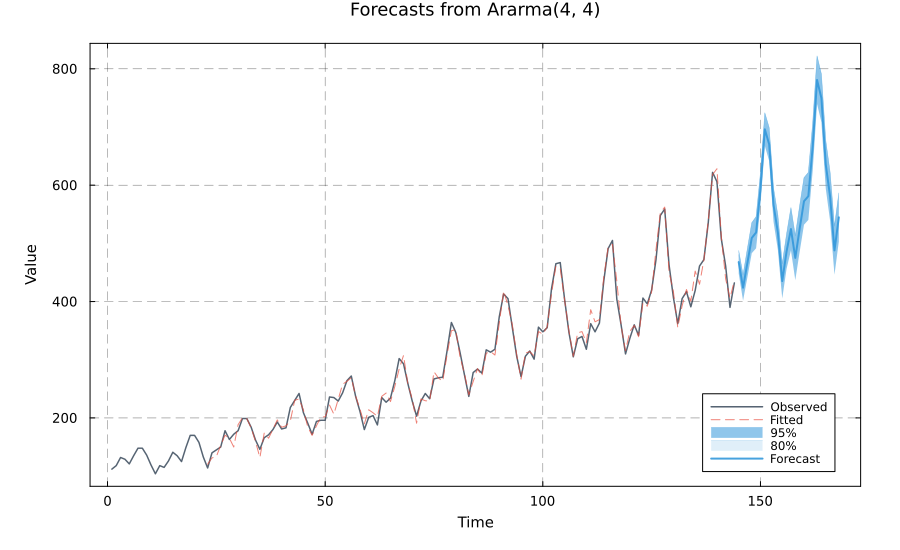

In [13]:
# ARARMA Formula interface

spec = ArarmaSpec(@formula(value = p() + q()))  # auto selection
fitted_ararma = fit(spec, (value=ap,))
fc = forecast(fitted_ararma, h=24)
plot(fc)


---

## Part VII: Intermittent Demand (Croston Methods)

Croston methods are specialised for **intermittent demand** — time series with many zero values and sporadic non-zero demands. Common in spare parts, slow-moving inventory, and low-volume products.

### Why Croston?

Standard methods (ARIMA, ETS) assume continuous demand. When more than ~50% of observations are zero, they produce biased forecasts. Croston decomposes the problem:

1. **Demand size** ($z_t$): magnitude when demand occurs
2. **Inter-arrival time** ($p_t$): periods between demands

### Method Variants

| Method | Key Feature |
|--------|-------------|
| **SBA** (Syntetos-Boylan Approximation) | Bias-corrected, best overall accuracy |
| **SBJ** (Shale-Boylan-Johnston) | Alternative bias correction |
| **Classic** (Croston 1972) | Original method |
| **Hyndman** (Shenstone & Hyndman 2005) | Fixed-alpha implementation |

In [9]:
# Intermittent demand data
demand = Float64[6, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 2, 0, 0, 0, 3, 0];

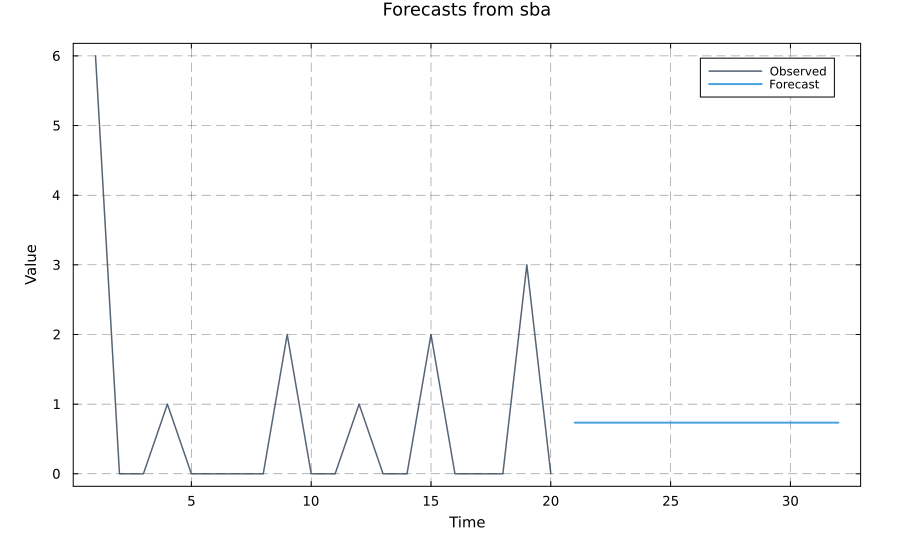

In [11]:

# Formula interface (recommended)
spec = CrostonSpec(@formula(demand = croston(method="sba")))
fitted_croston = fit(spec, (demand=demand,))
fc = forecast(fitted_croston, h=12)
plot(fc)

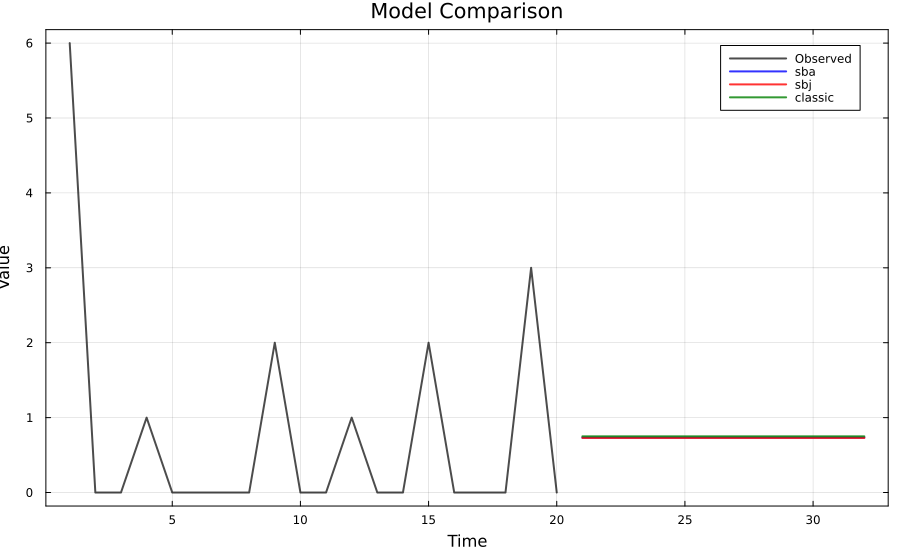

In [13]:
# Compare variants
models = model(
    CrostonSpec(@formula(demand = croston(method="sba"))),
    CrostonSpec(@formula(demand = croston(method="sbj"))),
    CrostonSpec(@formula(demand = croston(method="classic"))),
    names = ["sba", "sbj", "classic"]
)
fitted_all = fit(models, (demand=demand,))
fc_all = forecast(fitted_all, h=12)
plot(fc_all)

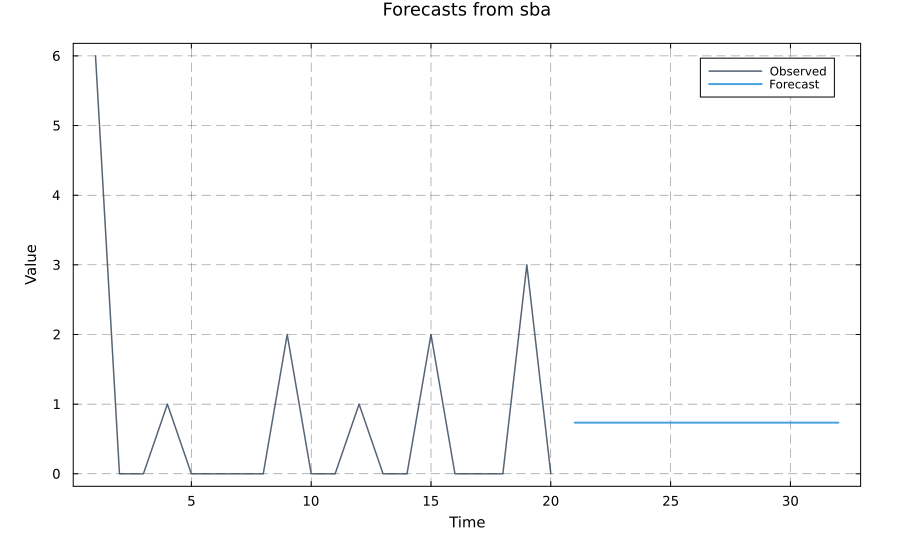

In [15]:
# Advanced: custom optimisation parameters
spec = CrostonSpec(@formula(demand = croston(
    method = "sba",
    cost_metric = "mar",
    number_of_params = 2,
    optimize_init = true,
    init_strategy = "mean"
)))

fitted_croston = fit(spec, (demand=demand,))
fc = forecast(fitted_croston, h=12)
plot(fc)


---

## Part VIII: The Formula Grammar

Durbyn's formula interface provides a **declarative, composable** way to specify models. The `@formula` macro parses a model specification into a `ModelFormula` that is interpreted by each model spec.

### Grammar Elements

| Term | Meaning | Example |
|------|---------|---------|
| `p()`, `p(k)`, `p(lo, hi)` | AR order (auto, fixed, or range) | `p(1,3)` |
| `q()`, `q(k)`, `q(lo, hi)` | MA order | `q(0,2)` |
| `d()`, `d(k)` | Differencing order | `d(1)` |
| `P()`, `Q()`, `D()` | Seasonal AR, MA, differencing | `P(0,1)` |
| `e("X")` | Error type: `"A"`, `"M"`, `"Z"` | `e("Z")` |
| `t("X")` | Trend type | `t("A")` |
| `s("X")` | Season type | `s("M")` |
| `drift(:auto)` | Include drift term | `drift(true)` |
| `ses()` | SES specification | |
| `holt(damped=true)` | Holt specification | |
| `hw(seasonal="mul")` | Holt-Winters specification | |
| `croston(method="sba")` | Croston specification | |
| `bats(seasonal_periods=12)` | BATS specification | |
| `tbats(seasonal_periods=12)` | TBATS specification | |
| `theta(model=:DOTM)` | Theta specification | |
| `arar()` | ARAR specification | |
| `naive_term()` | Naive benchmark | |
| `snaive_term()` | Seasonal naive | |
| `rw_term(drift=true)` | Random walk | |
| `meanf_term()` | Mean forecast | |

### Model Specs

Each model family has a corresponding `Spec` type:


---

## Part IX: Model Collections and Comparison

### General model definition

In [ ]:
# ETS variants
EtsSpec(@formula(value = e("Z") + t("Z") + s("Z")))
SesSpec(@formula(value = ses()))
HoltSpec(@formula(value = holt(damped=true)))
HoltWintersSpec(@formula(value = hw(seasonal="multiplicative")); m=12)

# ARIMA
ArimaSpec(@formula(value = p() + q() + d() + P() + Q() + D()))

# BATS / TBATS
BatsSpec(@formula(value = bats(seasonal_periods=12)))
TbatsSpec(@formula(value = tbats(seasonal_periods=12)))

# Theta
ThetaSpec(@formula(value = theta(model=:DOTM, nmse=5)))

# ARAR / ARARMA
ArarSpec(@formula(value = arar()))
ArarmaSpec(@formula(value = p() + q()))

# Croston
CrostonSpec(@formula(value = croston(method="sba")))

# Benchmarks
NaiveSpec(@formula(value = naive_term()))
SnaiveSpec(@formula(value = snaive_term()); m=12)
RwSpec(@formula(value = rw_term(drift=true)))
MeanfSpec(@formula(value = meanf_term()))

### Defining Multiple Models

Use `model()` to bundle multiple specs for joint fitting and comparison:

In [9]:
  models = model(
      ArimaSpec(@formula(value = p() + q() + P() + Q() + d() + D()),),
      BatsSpec(@formula(value = bats())),
      TbatsSpec(@formula(value = tbats())),
      EtsSpec(@formula(value = e("Z") + t("Z") + s("Z") + drift(:auto))),
      SesSpec(@formula(value = ses())),
      HoltSpec(@formula(value = holt(damped=true))),
      HoltWintersSpec(@formula(value = hw(seasonal="multiplicative"))),
      CrostonSpec(@formula(value = croston(method="sba"))),
      ThetaSpec(@formula(value = theta(model=:DOTM))),
      NaiveSpec(@formula(value = naive_term())),
      SnaiveSpec(@formula(value = snaive_term())),
      names=["arima", "bats", "tbats", "ets", "ses", "holt", "hw", "croston", "theta", "naive", "snaive"]
          )

ModelCollection with 11 models


### Fitting and Forecasting

In [11]:
# Single series
data = (value = ap,)
fitted_models = fit(models, data, m=12)
fc = forecast(fitted_models, h=24)


ForecastModelCollection
  Models: arima, bats, tbats, ets, ses, holt, hw, croston, theta, naive, snaive
  Metadata:
    h => 24


In [12]:
# Convert to tidy table
fc_tbl = as_table(fc)
glimpse(fc_tbl)

Table glimpse
  Rows: 264
  Columns: 8
  step                :: Int64  [1, 2, 3, 4, 5, …]
  mean                :: Float64  [445.40896880745896, 419.98944629887734, 448.66681520755185, 491.2012720154239, 502.6757585356252, …]
  lower_80            :: Union{Missing, Float64}  [430.83176469767966, 403.00190571059846, 429.5268111399188, 470.65702855884643, 481.0668607313637, …]
  upper_80            :: Union{Missing, Float64}  [459.98617291723826, 436.9769868871562, 467.8068192751849, 511.7455154720014, 524.2846563398867, …]
  lower_95            :: Union{Missing, Float64}  [423.11505897300333, 394.0092449288371, 419.39470502088966, 459.78156301026695, 469.6278012152646, …]
  upper_95            :: Union{Missing, Float64}  [467.7028786419146, 445.96964766891756, 477.93892539421404, 522.6209810205809, 535.7237158559859, …]
  model               :: String  ["ARIMA(2,1,1)(0,1,0)[12]", "ARIMA(2,1,1)(0,1,0)[12]", "ARIMA(2,1,1)(0,1,0)[12]", "ARIMA(2,1,1)(0,1,0)[12]", "ARIMA(2,1,1)(0,1,0)[12]", 


### Accuracy Evaluation

In [13]:
# Compare against actual test data
test_data = (value = test_values,)  # your hold-out data
acc = accuracy(fc, test_data)
glimpse(acc)

UndefVarError: UndefVarError: `test_values` not defined in `Main`
Suggestion: check for spelling errors or missing imports.


---

## Part X: Panel Data Workflow

Panel data is the production workflow for fitting models to many time series simultaneously.

### Creating PanelData

In [34]:
train_subset = distinct(select(train_all, :series,))
println(train_subset.series)


String7["N1402", "N1403", "N1404", "N1405", "N1406", "N1407", "N1408", "N1409", "N1410", "N1411", "N1412", "N1413", "N1414", "N1415", "N1416", "N1417", "N1418", "N1419", "N1420", "N1421", "N1422", "N1423", "N1424", "N1425", "N1426", "N1427", "N1428", "N1429", "N1430", "N1431", "N1432", "N1433", "N1434", "N1435", "N1436", "N1437", "N1438", "N1439", "N1440", "N1441", "N1442", "N1443", "N1444", "N1445", "N1446", "N1447", "N1448", "N1449", "N1450", "N1451", "N1452", "N1453", "N1454", "N1455", "N1456", "N1457", "N1458", "N1459", "N1460", "N1461", "N1462", "N1463", "N1464", "N1465", "N1466", "N1467", "N1468", "N1469", "N1470", "N1471", "N1472", "N1473", "N1474", "N1475", "N1476", "N1477", "N1478", "N1479", "N1480", "N1481", "N1482", "N1483", "N1484", "N1485", "N1486", "N1487", "N1488", "N1489", "N1490", "N1491", "N1492", "N1493", "N1494", "N1495", "N1496", "N1497", "N1498", "N1499", "N1500", "N1501", "N1502", "N1503", "N1504", "N1505", "N1506", "N1507", "N1508", "N1509", "N1510", "N1511", "N

In [47]:
# From M3 monthly training data
train_subset = query(train_all, row -> row.series in ["N2034", "N2035", "N2036", "N2037"])
glimpse(train_subset)
train_subset = select(train_subset, :series, :date, :value)

panel = PanelData(train_subset; groupby=:series, date=:date, m=12)
glimpse(panel)

Table glimpse
  Rows: 460
  Columns: 9
  data                :: String3  [String3("M3"), String3("M3"), String3("M3"), String3("M3"), String3("M3"), …]
  series              :: String7  [String7("N2034"), String7("N2034"), String7("N2034"), String7("N2034"), String7("N2034"), …]
  period              :: String7  [String7("MONTHLY"), String7("MONTHLY"), String7("MONTHLY"), String7("MONTHLY"), String7("MONTHLY"), …]
  type                :: String15  [String15("INDUSTRY"), String15("INDUSTRY"), String15("INDUSTRY"), String15("INDUSTRY"), String15("INDUSTRY"), …]
  description         :: String  ["Paperboard, total", "Paperboard, total", "Paperboard, total", "Paperboard, total", "Paperboard, total", …]
  value_type          :: String3  [String3("x"), String3("x"), String3("x"), String3("x"), String3("x"), …]
  time                :: Float64  [1983.0, 1983.08333333333, 1983.16666666667, 1983.25, 1983.33333333333, …]
  date                :: Dates.Date  [Dates.Date("1983-01-01"), Dates.Date


### Fitting Models to Panel Data

When you `fit` a model collection to a `PanelData` object, Durbyn fits each model to each series **in parallel** (using Julia's threading):

In [48]:
# Define models
models = model(
    ArimaSpec(@formula(value = p() + q() + d() + P() + Q() + D())),
    EtsSpec(@formula(value = e("Z") + t("Z") + s("Z"))),
    ThetaSpec(@formula(value = theta(model=:DOTM))),
    SnaiveSpec(@formula(value = snaive_term()); m=12),
    names=["arima", "ets", "theta", "snaive"]
)

ModelCollection with 4 models: arima, ets, theta, snaive

In [49]:
# Fit all models to all series (parallel)
fitted_panel = fit(models, panel)

# Forecast
fc_panel = forecast(fitted_panel, h=18);  # M3 monthly has 18-step test horizon
glimpse(fc_panel)

Grouping data by series...
Found 4 groups
Fitting models sequentially...
  Progress: 1/4 (25.0%)
  Progress: 2/4 (50.0%)
  Progress: 3/4 (75.0%)
  Progress: 4/4 (100.0%)
Completed in 9.51s
Grouping data by series...
Found 4 groups
Fitting models sequentially...
  Progress: 1/4 (25.0%)
  Progress: 2/4 (50.0%)
  Progress: 3/4 (75.0%)
  Progress: 4/4 (100.0%)
Completed in 2.26s
Grouping data by series...
Found 4 groups
Fitting models sequentially...
  Progress: 1/4 (25.0%)
  Progress: 2/4 (50.0%)
  Progress: 3/4 (75.0%)
  Progress: 4/4 (100.0%)
Completed in 0.08s
Grouping data by series...
Found 4 groups
Fitting models sequentially...
  Progress: 1/4 (25.0%)
  Progress: 2/4 (50.0%)
  Progress: 3/4 (75.0%)
  Progress: 4/4 (100.0%)
Completed in 0.0s
Table glimpse
  Rows: 288
  Columns: 9
  series              :: String7  [String7("N2034"), String7("N2034"), String7("N2034"), String7("N2034"), String7("N2034"), …]
  step                :: Int64  [1, 2, 3, 4, 5, …]
  mean                :: Fl

In [50]:
# Get tidy forecast table
fc_tbl = as_table(fc_panel)
glimpse(fc_tbl)

Table glimpse
  Rows: 288
  Columns: 9
  series              :: String7  [String7("N2034"), String7("N2034"), String7("N2034"), String7("N2034"), String7("N2034"), …]
  step                :: Int64  [1, 2, 3, 4, 5, …]
  mean                :: Float64  [7263.0558915809725, 6964.9611865654615, 7213.645634303974, 6919.2844715599385, 7087.437947239861, …]
  lower_80            :: Float64  [7070.41170889831, 6747.686777049039, 6979.985667697498, 6674.326695564905, 6834.5317525742885, …]
  upper_80            :: Float64  [7455.700074263635, 7182.235596081884, 7447.305600910449, 7164.242247554972, 7340.344141905434, …]
  lower_95            :: Float64  [6968.432038713436, 6632.668652372015, 6856.2935530532195, 6544.653881897108, 6700.651300226594, …]
  upper_95            :: Float64  [7557.679744448509, 7297.2537207589085, 7570.997715554728, 7293.9150612227695, 7474.224594253129, …]
  model               :: String  ["Regression with ARIMA(1,0,1)(0,1,1)[12] errors", "Regression with ARIMA(1,0,


### Evaluating Panel Forecasts

In [51]:
# Prepare test data
test_subset = query(test_all, row -> row.series in ["N2034", "N2035", "N2036", "N2037"])
test_subset = select(test_subset, :series, :date, :value)

# Compute accuracy
acc = accuracy(fc_panel, test_subset)
glimpse(acc)

Table glimpse
  Rows: 16
  Columns: 8
  model               :: Any  ["arima", "arima", "arima", "arima", "ets", …]
  MPE                 :: Any  [10.784047728309208, -0.5657101795077505, 10.974409126229007, -40.408342602911326, 6.985818886918527, …]
  ME                  :: Any  [793.3829053493102, -38.5825488793098, 895.3543345748379, -1388.7649124065913, 518.1690185130087, …]
  series              :: Any  [String7("N2037"), String7("N2034"), String7("N2035"), String7("N2036"), String7("N2037"), …]
  RMSE                :: Any  [936.5967697908771, 127.89603982667575, 1223.71453707527, 1733.0863193885984, 685.9270880615269, …]
  MAE                 :: Any  [819.0666351777309, 97.02968741736933, 962.8220245207265, 1636.4290608658573, 575.1877789085479, …]
  MAPE                :: Any  [11.18036485689845, 1.3697062401627234, 12.114838734456377, 44.07120287323782, 7.842497416849174, …]
  ACF1                :: Any  [0.4455732354332721, 0.11049663977786542, 0.10245281471131336, 0.523328755

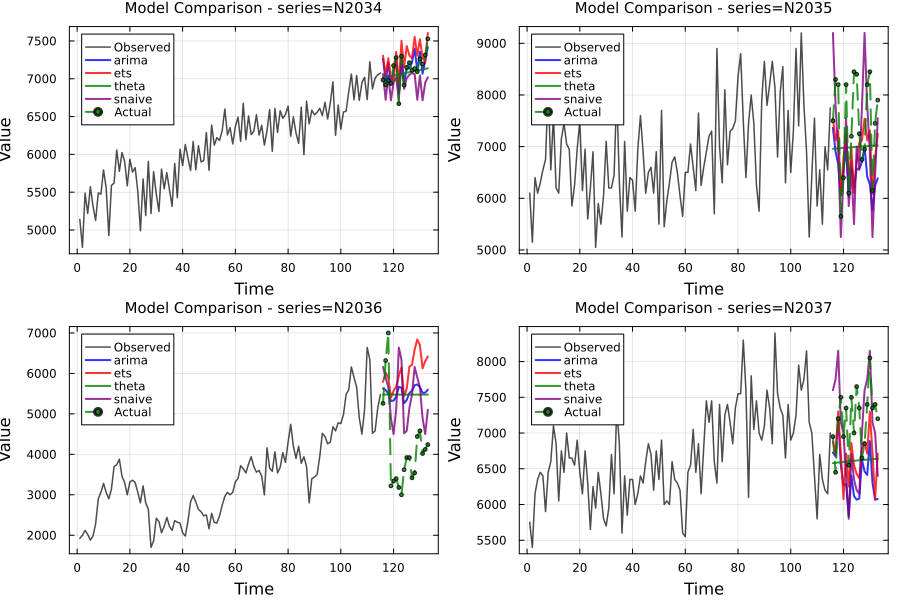

In [57]:
plot(fc_panel, series=:all, facet=true, actual=test_subset) 


### Inspecting Results

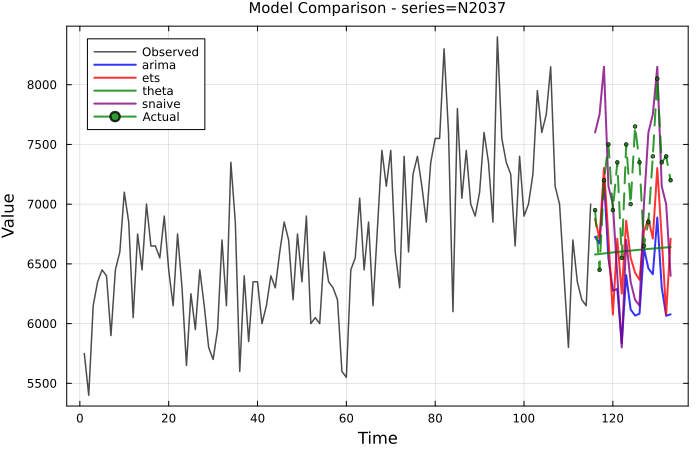

In [56]:
# List available series
list_series(fc_panel)

# Check for failed fits
# failed_groups(fitted_panel)
# successful_models(fitted_panel)

# Plot forecasts
plot(fc_panel)                              # first series
plot(fc_panel, series=:all, facet=true)     # all series in grid
plot(fc_panel, series="N2037", actual=test_subset)  # with actuals

# Model Selection Guide

| Data Characteristics | Recommended Models | Why |
|---|---|---|
| Short series (n < 30), no pattern | SES, Naive, Mean | Few parameters, avoids overfitting |
| Short series (n < 30), with trend | Holt (damped), RW with drift | Captures trend with minimal parameters |
| Moderate length, linear trend, no season | Holt (damped), ARIMA(p,1,q), RW with drift | Damped Holt safest for longer horizons |
| Moderate length, trend + single season | Holt-Winters, ETS(Z,Z,Z), ARIMA, Theta | HW or auto ETS for interpretability |
| Long series, trend + single season | Auto ARIMA, ETS(Z,Z,Z), BATS, Theta (DOTM) | Auto-selection leverages large samples |
| Multiple integer seasonal periods | BATS, TBATS | Only models handling dual+ seasonality |
| Non-integer seasonal period (e.g. 52.18 weeks) | TBATS | Fourier representation handles fractional periods |
| Very long seasonal cycle (m > 350) | TBATS | Fourier compression keeps state dimension tractable |
| High-frequency data (hourly, sub-daily) | TBATS, BATS | Multiple overlapping cycles (daily + weekly) |
| Intermittent demand (many zeros) | Croston SBA, Croston SBJ | Explicitly models zero-inflated demand |
| Slow-moving / spare parts inventory | Croston SBA | Bias-corrected rate forecasting |
| Noisy, irregular, hard to model | Theta (DOTM), ARAR, Auto ARIMA | Theta robust; ARAR adaptive; auto ARIMA systematic |
| Strong seasonality, minimal trend | Seasonal Naive, Holt-Winters, ETS | SNAIVE as benchmark, HW/ETS for improvement |
| Stationary, mean-reverting | Mean, SES, ARIMA(p,0,q) | No differencing needed |
| Non-stationary, unknown structure | Auto ARIMA, ARAR, ARARMA | Automatic differencing / adaptive reduction |
| New product / technology adoption | Bass, Gompertz | S-curve lifecycle modeling |
| Complex autocorrelation, no season | ARARMA, ARIMA | AR + MA captures both long and short memory |
| Heteroscedastic (changing variance) | Any model with `lambda="auto"` | Box-Cox stabilizes variance |
| Unknown / exploratory | Auto ARIMA + ETS(Z,Z,Z) + Theta + SNAIVE | Compare all, pick best by holdout accuracy |


## References

#### Exponential Smoothing (ETS)

- Hyndman, R.J., Koehler, A.B., Snyder, R.D., & Grose, S. (2002). A state space framework for automatic forecasting using exponential smoothing methods. International Journal of Forecasting, 18(3), 439-454.
- Hyndman, R.J., Akram, Md., & Archibald, B. (2008). The admissible parameter space for exponential smoothing models. Annals of the Institute of Statistical Mathematics, 60(2), 407-426.
- Hyndman, R.J., Koehler, A.B., Ord, J.K., & Snyder, R.D. (2008). Forecasting with Exponential Smoothing: The State Space Approach. Springer.

#### BATS / TBATS

- De Livera, A.M., Hyndman, R.J., & Snyder, R.D. (2011). Forecasting time series with complex seasonal patterns using exponential smoothing. JASA, 106(496), 1513-1527.

#### ARIMA / Auto ARIMA

- Hyndman, R.J., & Khandakar, Y. (2008). Automatic time series forecasting: the forecast package for R. Journal of Statistical Software, 27(3).
- Box, G.E.P., Jenkins, G.M., & Reinsel, G.C. (1994). Time Series Analysis, Forecasting and Control.
- Box, G.E.P., Jenkins, G.M., & Reinsel, G.C. (2015). Time Series Analysis: Forecasting and Control (5th ed.). Wiley.
- Hamilton, J.D. (1994). Time Series Analysis.
- Kunst, R. (2011). Applied Time Series Analysis — Part II. University of Vienna.

#### Theta Method

- Assimakopoulos, V., & Nikolopoulos, K. (2000). The theta model: a decomposition approach to forecasting. IJF, 16(4), 521-530.
- Fiorucci, J.A., Pellegrini, T.R., Louzada, F., Petropoulos, F., & Koehler, A.B. (2016). Models for optimising the theta method and their relationship to state space models. IJF, 32(4), 1151-1161.

#### Croston's Method (Intermittent Demand)

- Croston, J.D. (1972). Forecasting and stock control for intermittent demands. Operational Research Quarterly, 23(3), 289-303.
- Syntetos, A.A., & Boylan, J.E. (2005). The accuracy of intermittent demand estimates. IJF, 21(2), 303-314.
- Shenstone, L., & Hyndman, R.J. (2005). Stochastic models underlying Croston's method for intermittent demand forecasting. Journal of Forecasting, 24, 389-402.
- Kourentzes, N. (2014). On intermittent demand model optimisation and selection. International Journal of Production Economics, 156, 180-190.

#### ARAR / ARARMA

- Brockwell, P.J., & Davis, R.A. (2016). Introduction to Time Series and Forecasting. Springer.
- Parzen, E. (1982). ARARMA Models for Time Series Analysis and Forecasting. Journal of Forecasting, 1(1), 67-82.

#### Box-Cox Transformation

- Box, G.E.P., & Cox, D.R. (1964). An analysis of transformations. JRSS Series B, 26, 211-246.
- Guerrero, V.M. (1993). Time-series analysis supported by power transformations. Journal of Forecasting, 12, 37-48.

#### Unit Root Tests (ADF, KPSS, PP)

- Dickey, D.A., & Fuller, W.A. (1979). Distribution of the Estimators for Autoregressive Time Series with a Unit Root. JASA, 75, 427-431.
- Dickey, D.A., & Fuller, W.A. (1981). ADF test critical values.
- Kwiatkowski, D., Phillips, P.C.B., Schmidt, P., & Shin, Y. (1992). Testing the Null Hypothesis of Stationarity Against the Alternative of a Unit Root. Journal of Econometrics, 54, 159-178.
- Phillips, P.C.B., & Perron, P. (1988). Testing for a unit root in time series regression. Biometrika, 75(2), 335-346.
- MacKinnon, J.G. (1991). Critical Values for Cointegration Tests. In Engle & Granger (eds.), Oxford.
- Said, S.E., & Dickey, D.A. (1984). Testing for Unit Roots in ARMA Models of Unknown Order. Biometrika, 71, 599-607.

#### Seasonal Differencing (OCSB Test)

- Osborn, D.R., Chui, A.P.L., Smith, J., & Birchenhall, C.R. (1988). Seasonality and the order of integration for consumption. Oxford Bulletin of Economics and Statistics, 50(4), 361-377.
- Wang, X., Smith, K.A., & Hyndman, R.J. (2006). Characteristic-based clustering for time series data. Data Mining and Knowledge Discovery, 13(3), 335-364.
- Osborn, D.R. (1990). A survey of seasonality in UK macroeconomic variables. IJF, 6, 327-336.

#### Diffusion Models

- Bass, F.M. (1969). A new product growth model for consumer durables. Management Science, 15(5), 215-227.
- Rogers, E.M. (1962). Diffusion of Innovations. Free Press.
- Gompertz, B. (1825). On the nature of the function expressive of the law of human mortality. Philosophical Transactions of the Royal Society, 115, 513-583.
- Bemmaor, A.C. (1994). Modeling the diffusion of new durable goods. In Laurent et al. (Eds.), Kluwer.
- Jukic, D., Kralik, G., & Scitovski, R. (2004). Least-squares fitting Gompertz curve. JCAM, 169, 359-375.
- Sharif, M.N., & Islam, M.N. (1980). The Weibull distribution as a general model for forecasting technological change. Technological Forecasting and Social Change, 18(3), 247-256.

#### Datasets

- Campbell, M.J., & Walker, A.M. (1977). Mackenzie River lynx data. JRSS Series A, 140, 411-431.
- Andrews, D.F., & Herzberg, A.M. (1985). Data: A Collection of Problems from Many Fields. Springer.

#### General Forecasting

- Hyndman, R.J., & Athanasopoulos, G. (2021). Forecasting: Principles and Practice (3rd ed.). OTexts.